In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate
from scipy import interpolate

In [5]:
path = "/Users/atalianb/Documents/data_LBSG/LSBG/LSBG/"

In [6]:
D564 = np.loadtxt(path+'D564-8_rotmod.dat')

In [7]:
vecRp_D564 = np.array([row[0] for row in D564])# galactocentric distance [kpc]
vecvRp_D564 = np.array([row[1] for row in D564])# rotation velocity [km/s]
vecerrvRp_D564 = np.array([row[2] for row in D564])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

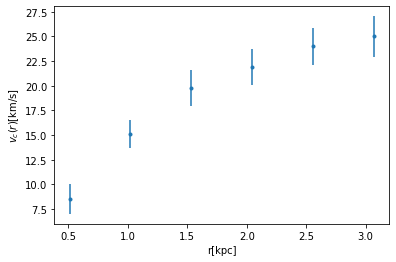

In [8]:
plt.errorbar(vecRp_D564,vecvRp_D564,yerr=vecerrvRp_D564,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [9]:
##Values
####
eps_ = 2.5e-4#
m_a_ = 1.0e-22#eV/c^2
G_kpc = 4.302e-6#kpc/SolarMass(km/s)^2
####
##Integration values
###
x0_0 = 3.#first integration
x0_0v1 = 0.01# Start of integration. Use 0.01 for continuity in l=3 solution, for 0,1,2 0.0 it's ok
xf_0v1 = 10.# End of integration
step_0 = 0.5#Step to integrate from x0_0 until xf_0v1 is reached
###l=1 
u1_1 = -3.7# 1st trial value of unknown init. cond.
u2_1 = -2.2# 2nd trial value of unknown init. cond.
u_1 = np.array([u1_1, u2_1])

In [10]:
def Integrate(func,x0,y0,x,h):
    # Finds value of y for a given x using step size h 
    # and initial value y0 at x0.
    def RK4(func,x0,y0,h):
        K0 = h*func(x0,y0)
        K1 = h*func(x0 + 0.5*h, y0 + 0.5*K0)
        K2 = h*func(x0 + 0.5*h, y0 + 0.5*K1)
        K3 = h*func(x0 + h, y0 + K2)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    while x0 < x:
         # Count number of iterations using step size or
        h = min(h,x - x0)# step height h
        y0 = y0 + RK4(func,x0,y0,h)#update next value of y
        x0 = x0 + h#update next value of x
        X.append(x0)
        Y.append(y0)
    return np.array(X),np.array(Y)

In [11]:
def shooting(func,u,x0,x,xf,step,k,h=0.01):
    def res(u):# Boundary condition residual
        X,Y = Integrate(func,x0,IC(u,k),x,h)
        y = Y[len(Y) - 1]#last value of Y
        r = np.zeros(len(u))
        r[0] = y[0]#y0(inf)=0
        r[1] = y[2]/x + y[3]#y_3(inf)/r + y_4(inf)=0
        return r
    x_list = []
    root_list = []
    while x<=xf:
        x_list.append(x)
        root = optimize.root(res,u)
        u = root.x
        root_temp = optimize.root(res,root.x)
        root_list.append(root_temp.x)
        X,Y = Integrate(func,x0,IC(root_temp.x,k),x,h)
        x = x+step
    return X,Y,root_temp,np.array(x_list),np.array(root_list)

In [12]:
def IC(u,k):#Initial conditions array, the first correspond to the initial condition in phi
    return np.array([k,0.0,u[0],0.0,u[1]])

In [13]:
def f1(x,y):
    l = 1.
    F = np.zeros(5)
    if x==0:
        F[0] = y[1]
        F[1] = 2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = 0.
        F[4] = 0.
    else:
        F[0] = y[1]
        F[1] = -2.*(l+1.)*y[1]/x +2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = (2.*l+1.)*x**(2.*l)*y[0]**2. - 2.*y[3]/x
        F[4] = 0.
    return F

In [14]:
def Mass_func(r,phi,l):
    Int = np.zeros(len(r))
    dr = np.diff(r)[0]
    phi_array = np.array(phi[:,0])
    for i in range(0,len(r)-1):
        Int[i+1] = dr*(phi_array[i+1]**2.*r[i+1]**(2.*l+2.)) + Int[i]
    return Int

In [15]:
def Vc2_cir(r,eps,M):
    units =8.95e10*eps**2.
    return (units*M)/r
####
##Units for r in kpc
###
def r_units(r,eps,m_a):
    return (6.39e-27*r)/(eps*m_a)

In [20]:
#The function integrate f0 with the shooting method,
#integrates to find the M(r) and returns the r[kpc] and Vc[km/s] 
#if the last element of r[kpc] array is minor than the last element of the r data array
#takes the last element of the M(r) array and compute the Vc^2 for the rest of the r elements
def Vc_xy(r,m_a,eps,l=1.):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(f1,u_1,x0_0v1,x0_0,xf_0v1,step_0,k=1.)
    M_r0 = Mass_func(X0,Y0,l=1.)#Integrates rho(r) to obtain M(r)
    Vc2_r0 = Vc2_cir(X0,eps,M_r0)#Vc^2[km/s]^2 theoretical
    X0_units = r_units(X0,eps,m_a)#r[kpc] theoretical
    M_r0_units = M_r0*eps*1.34e-10/m_a#M(r) with Solar Mass units
    if X0_units[-1]<r[-1]:
        #array from last element of the r[kpc] theoretical to the last element of the data array,
        # with 80 elements. It can be replaced by np.arange(X0_units[-1],vecRp_data[-1],0.1) 
        #but you have to be careful in the next function with interpolate
        r_array = np.linspace(X0_units[-1],r[-1],80)
        Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array#Computes Vc^2 with with the last result from M(r)
        Vc2_total = np.append(Vc2_r0,Vc2_rmayor)#creates an array of Vc^2 with Vc2_r0 and Vc2_rmayor
        r_total = np.append(X0_units,r_array)
        return r_total,np.sqrt(Vc2_total)
    else:
        return X0_units,np.sqrt(Vc2_r0)

In [21]:
def Vc_xi2(r,m_a,eps,l=1.):
    Vc = Vc_xy(r,m_a,eps)
    #If you want to use np.arange in the previous function, It is recommended to use extrapolate
    f = interpolate.interp1d(Vc[0],Vc[1],fill_value='extrapolate')
    Vc_new = f(r)
    return Vc_new

# $\chi^{2}$

# $\epsilon$

In [41]:
def Chi2_eps_D564(parameter):
    eps = np.exp(parameter)
    model = Vc_xi2(vecRp_D564,m_a_,eps,l=1.)
    xi = np.sum((vecvRp_D564-model)**2./(vecerrvRp_D564)**2.)
    return xi

In [42]:
x0_eps_D564 = np.array(np.log(1.0e-4))
LS_eps_D564 = optimize.minimize(Chi2_eps_D564,x0_eps_D564,method='L-BFGS-B',bounds=((np.log(1.0e-6),np.log(1.0e-3)),))
print(LS_eps_D564)

      fun: 17.11737706888298
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.10542677e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([-9.30276644])


In [43]:
print(np.exp(LS_eps_D564.x))

[9.11716614e-05]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

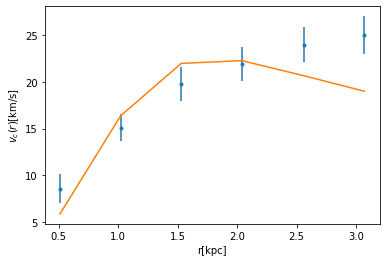

In [44]:
plt.errorbar(vecRp_D564,vecvRp_D564,yerr=vecerrvRp_D564,fmt='.')
plt.plot(vecRp_D564,Vc_xi2(vecRp_D564,m_a_,np.asscalar(np.exp(LS_eps_D564.x))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

$m_{a}$

In [45]:
def Chi2_m_a_D564(parameter):
    m_a = np.exp(parameter)
    model = Vc_xi2(vecRp_D564,m_a,eps_,l=1.)
    xi = np.sum((vecvRp_D564-model)**2./(vecerrvRp_D564)**2.)
    return xi

In [46]:
x0_m_a_D564 = np.array(np.log(1.0e-23))
LS_m_a_D564 = optimize.minimize(Chi2_m_a_D564,x0_m_a_D564,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),))
print(LS_m_a_D564)

      fun: 123.7246972364415
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.84217071e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 3
     njev: 6
   status: 0
  success: True
        x: array([-52.96993188])


In [47]:
print(np.exp(LS_m_a_D564.x))

[9.89579923e-24]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

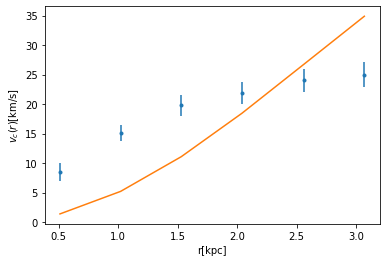

In [48]:
plt.errorbar(vecRp_D564,vecvRp_D564,yerr=vecerrvRp_D564,fmt='.')
plt.plot(vecRp_D564,Vc_xi2(vecRp_D564,np.asscalar(np.exp(LS_m_a_D564.x)),eps_))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Dos parámetros

$m_{a}$ y $\epsilon$

In [49]:
def Vc_l0_m_a_eps(r,params):
    m_a,eps = params
    return Vc_xi2(r,m_a,eps,l=1.)

In [50]:
def Xi2_m_a_eps_D564(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_D564,par)
    xi  = np.sum((vecvRp_D564-model)**2./(vecerrvRp_D564)**2.)
    return xi

In [51]:
x0_m_a_eps_D564 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_D564 = optimize.minimize(Xi2_m_a_eps_D564,x0_m_a_eps_D564,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.)),))
print(LS_m_a_eps_D564)

      fun: 11.540796944673634
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.36983746e-05, -1.27009504e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 90
      nit: 12
     njev: 30
   status: 0
  success: True
        x: array([-50.87727964,  -9.2329417 ])


In [53]:
print(np.exp(LS_m_a_eps_D564.x))

[8.02191766e-23 9.77652165e-05]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 1.0, '$m_{a}$=8.021917664114911e-23$\\epsilon$=9.776521653211969e-05')

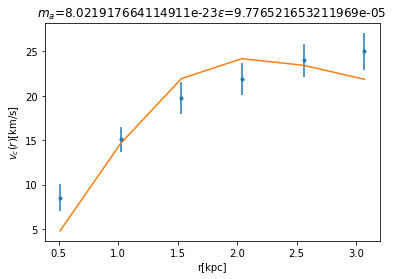

In [55]:
plt.errorbar(vecRp_D564,vecvRp_D564,yerr=vecerrvRp_D564,fmt='.')
plt.plot(vecRp_D564,Vc_xi2(vecRp_D564,np.asscalar(np.exp(LS_m_a_eps_D564.x[0])),np.asscalar(np.exp(LS_m_a_eps_D564.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title(r'$m_{a}$='+str(np.exp(LS_m_a_eps_D564.x[0]))+r'$\epsilon$='+str(np.exp(LS_m_a_eps_D564.x[1])))

In [ ]:
def rescaling(phi_0,l):
    lmbd = (1./phi_0)**(1/(l+2.))
    return lmbd

# F563

In [57]:
F563 = np.loadtxt(path+'F563-V2_rotmod.dat')

In [58]:
vecRp_F563 = np.array([row[0] for row in F563])# galactocentric distance [kpc]
vecvRp_F563 = np.array([row[1] for row in F563])# rotation velocity [km/s]
vecerrvRp_F563 = np.array([row[2] for row in F563])# error in rotation velocity [km/s]

# $\epsilon$

In [59]:
def Chi2_eps_F563(parameter):
    eps = np.exp(parameter)
    model = Vc_xi2(vecRp_F563,m_a_,eps,l=1.)
    xi = np.sum((vecvRp_F563-model)**2./(vecerrvRp_F563)**2.)
    return xi

In [60]:
x0_eps_F563 = np.array(np.log(1.0e-4))
LS_eps_F563 = optimize.minimize(Chi2_eps_F563,x0_eps_F563,method='L-BFGS-B',bounds=((np.log(1.0e-6),np.log(1.0e-3)),))
print(LS_eps_F563)

      fun: 308.1993512861046
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.68434142e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 22
      nit: 7
     njev: 11
   status: 0
  success: True
        x: array([-8.2577958])


In [61]:
print(np.exp(LS_eps_F563.x))

[0.00025923]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

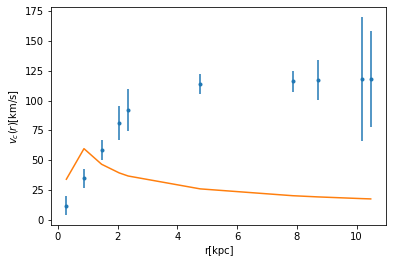

In [73]:
plt.errorbar(vecRp_F563,vecvRp_F563,yerr=vecerrvRp_F563,fmt='.')
plt.plot(vecRp_F563,Vc_xi2(vecRp_F563,m_a_,np.asscalar(np.exp(LS_eps_F563.x))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

$m_{a}$

In [63]:
def Chi2_m_a_F563(parameter):
    m_a = np.exp(parameter)
    model = Vc_xi2(vecRp_F563,m_a,eps_,l=1.)
    xi = np.sum((vecvRp_F563-model)**2./(vecerrvRp_F563)**2.)
    return xi

In [64]:
x0_m_a_F563 = np.array(np.log(1.0e-23))
LS_m_a_F563 = optimize.minimize(Chi2_m_a_F563,x0_m_a_F563,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),))
print(LS_m_a_F563)

      fun: 164.61422872123487
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.02532943])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 56
      nit: 6
     njev: 28
   status: 0
  success: True
        x: array([-52.4313687])


In [65]:
print(np.exp(LS_m_a_F563.x))

[1.6956878e-23]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

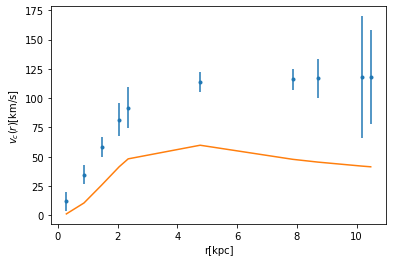

In [74]:
plt.errorbar(vecRp_F563,vecvRp_F563,yerr=vecerrvRp_F563,fmt='.')
plt.plot(vecRp_F563,Vc_xi2(vecRp_F563,np.asscalar(np.exp(LS_m_a_F563.x)),eps_))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Dos parámetros

$m_{a}$ y $\epsilon$

In [67]:
def Xi2_m_a_eps_F563(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_F563,par)
    xi  = np.sum((vecvRp_F563-model)**2./(vecerrvRp_F563)**2.)
    return xi

In [68]:
x0_m_a_eps_F563 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_F563 = optimize.minimize(Xi2_m_a_eps_F563,x0_m_a_eps_F563,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.)),))
print(LS_m_a_eps_F563)

      fun: 11.903321530796806
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -3.37507802e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 54
      nit: 13
     njev: 18
   status: 0
  success: True
        x: array([-53.20800619,  -7.52471962])


In [69]:
print(np.exp(LS_m_a_eps_F563.x))

[7.79931606e-24 5.39579934e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 1.0, '$m_{a}$=7.79931605779767e-24$\\epsilon$=0.0005395799337548258')

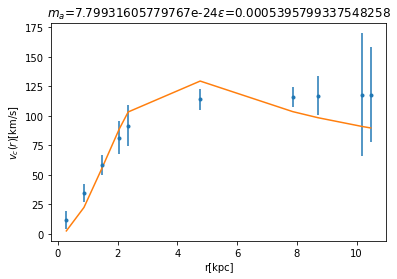

In [71]:
plt.errorbar(vecRp_F563,vecvRp_F563,yerr=vecerrvRp_F563,fmt='.')
plt.plot(vecRp_F563,Vc_xi2(vecRp_F563,np.asscalar(np.exp(LS_m_a_eps_F563.x[0])),np.asscalar(np.exp(LS_m_a_eps_F563.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title(r'$m_{a}$='+str(np.exp(LS_m_a_eps_F563.x[0]))+r'$\epsilon$='+str(np.exp(LS_m_a_eps_F563.x[1])))

# F568

In [75]:
F568 = np.loadtxt(path+"F568-3_rotmod.dat")

In [76]:
vecRp_F568 = np.array([row[0] for row in F568])# galactocentric distance [kpc]
vecvRp_F568 = np.array([row[1] for row in F568])# rotation velocity [km/s]
vecerrvRp_F568 = np.array([row[2] for row in F568])# error in rotation velocity [km/s]

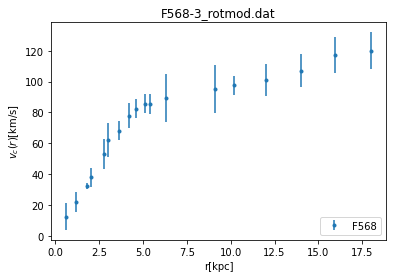

In [77]:
plt.errorbar(vecRp_F568,vecvRp_F568,yerr=vecerrvRp_F568,fmt='.',label='F568')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title('F568-3_rotmod.dat')
plt.legend(loc='lower right', prop={'size':10})

In [78]:
def Chi2_eps_F568(parameter):
    eps = np.exp(parameter)
    model = Vc_xi2(vecRp_F568,m_a_,eps,l=1.)
    xi = np.sum((vecvRp_F568-model)**2./(vecerrvRp_F568)**2.)
    return xi

In [79]:
x0_eps_F568 = np.array(np.log(1.0e-4))
LS_eps_F568 = optimize.minimize(Chi2_eps_F568,x0_eps_F568,method='L-BFGS-B',bounds=((np.log(1.0e-6),np.log(1.0e-3)),))
print(LS_eps_F568)

      fun: 944.7156959319321
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0005798])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([-8.17670796])


In [80]:
print(np.exp(LS_eps_F568.x))

[0.00028113]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

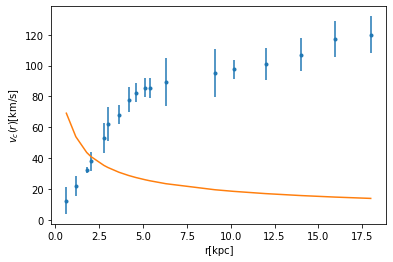

In [81]:
plt.errorbar(vecRp_F568,vecvRp_F568,yerr=vecerrvRp_F568,fmt='.')
plt.plot(vecRp_F568,Vc_xi2(vecRp_F568,m_a_,np.asscalar(np.exp(LS_eps_F568.x))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

$m_{a}$

In [82]:
def Chi2_m_a_F568(parameter):
    m_a = np.exp(parameter)
    model = Vc_xi2(vecRp_F568,m_a,eps_,l=1.)
    xi = np.sum((vecvRp_F568-model)**2./(vecerrvRp_F568)**2.)
    return xi

In [83]:
x0_m_a_F568 = np.array(np.log(1.0e-23))
LS_m_a_F568 = optimize.minimize(Chi2_m_a_F568,x0_m_a_F568,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),))
print(LS_m_a_F568)

      fun: 313.21598139777393
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.54747313e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([-52.61675773])


In [84]:
print(np.exp(LS_m_a_F568.x))

[1.40874525e-23]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

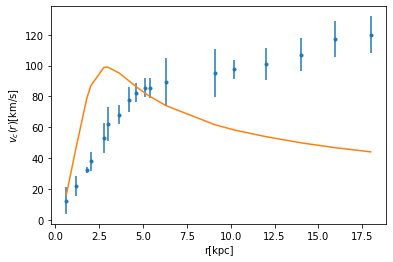

In [85]:
plt.errorbar(vecRp_F568,vecvRp_F568,yerr=vecerrvRp_F568,fmt='.')
plt.plot(vecRp_F568,Vc_xi2(vecRp_F568,np.asscalar(np.exp(LS_m_a_F568.x)),4.0e-4))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Dos parámetros

$m_{a}$ y $\epsilon$

In [86]:
def Xi2_m_a_eps_F568(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_F568,par)
    xi  = np.sum((vecvRp_F568-model)**2./(vecerrvRp_F568)**2.)
    return xi

In [87]:
x0_m_a_eps_F568 = np.array([np.log(1.0e-23),np.log(1.0e-5)])
LS_m_a_eps_F568 = optimize.minimize(Xi2_m_a_eps_F568,x0_m_a_eps_F568,method='L-BFGS-B',bounds=((np.log(1.0e-25),np.log(1.0e-21)),(np.log(1.0e-6),np.log(1.0e-3)),))
print(LS_m_a_eps_F568)

      fun: 72.11094956345354
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00000000e+00, 2.84217096e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 69
      nit: 12
     njev: 23
   status: 0
  success: True
        x: array([-53.57516005,  -7.72563293])


In [88]:
print(np.exp(LS_m_a_eps_F568.x))

[5.40261008e-24 4.41367399e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

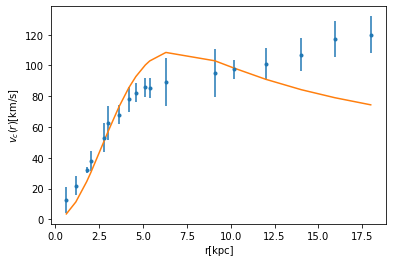

In [89]:
plt.errorbar(vecRp_F568,vecvRp_F568,yerr=vecerrvRp_F568,fmt='.')
plt.plot(vecRp_F568,Vc_xi2(vecRp_F568,np.asscalar(np.exp(LS_m_a_eps_F568.x[0])),np.asscalar(np.exp(LS_m_a_eps_F568.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# F571

In [90]:
F571 = np.loadtxt(path+"F571-V1_rotmod.dat")

In [91]:
vecRp_F571 = np.array([row[0] for row in F571])# galactocentric distance [kpc]
vecvRp_F571 = np.array([row[1] for row in F571])# rotation velocity [km/s]
vecerrvRp_F571 = np.array([row[2] for row in F571])# error in rotation velocity [km/s]

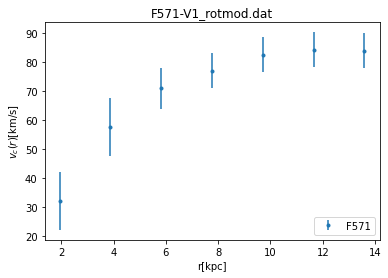

In [92]:
plt.errorbar(vecRp_F571,vecvRp_F571,yerr=vecerrvRp_F571,fmt='.',label='F571')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title('F571-V1_rotmod.dat')
plt.legend(loc='lower right', prop={'size':10})

# $\epsilon$

In [93]:
def Chi2_eps_F571(parameter):
    eps = np.exp(parameter)
    model = Vc_xi2(vecRp_F571,m_a_,eps,l=1.)
    xi = np.sum((vecvRp_F571-model)**2./(vecerrvRp_F571)**2.)
    return xi

In [94]:
x0_eps_F571 = np.array(np.log(1.0e-4))
LS_eps_F571 = optimize.minimize(Chi2_eps_F571,x0_eps_F571,method='L-BFGS-B',bounds=((np.log(1.0e-5),np.log(1.0e-2)),))
print(LS_eps_F571)

      fun: 188.83379375397766
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.68434192e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([-5.95540703])


In [95]:
print(np.exp(LS_eps_F571.x))

[0.00259179]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

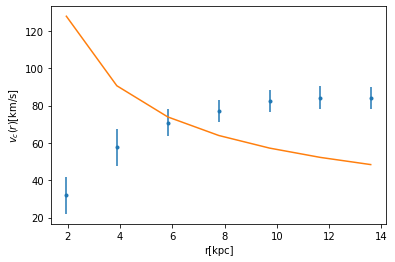

In [96]:
plt.errorbar(vecRp_F571,vecvRp_F571,yerr=vecerrvRp_F571,fmt='.')
plt.plot(vecRp_F571,Vc_xi2(vecRp_F571,m_a_,np.asscalar(np.exp(LS_eps_F571.x))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

$m_{a}$

In [97]:
def Chi2_m_a_F571(parameter):
    m_a = np.exp(parameter)
    model = Vc_xi2(vecRp_F571,m_a,eps_,l=1.)
    xi = np.sum((vecvRp_F571-model)**2./(vecerrvRp_F571)**2.)
    return xi

In [98]:
x0_m_a_F571 = np.array(np.log(1.0e-23))
LS_m_a_F571 = optimize.minimize(Chi2_m_a_F571,x0_m_a_F571,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),))
print(LS_m_a_F571)

      fun: 80.12694304420789
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.02813607])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 6
     njev: 30
   status: 0
  success: True
        x: array([-53.26609406])


In [99]:
print(np.exp(LS_m_a_F571.x))

[7.35917749e-24]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

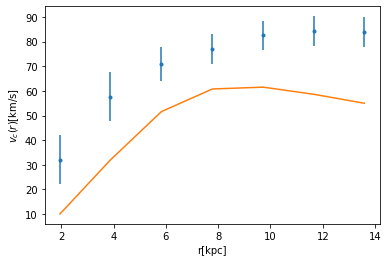

In [100]:
plt.errorbar(vecRp_F571,vecvRp_F571,yerr=vecerrvRp_F571,fmt='.')
plt.plot(vecRp_F571,Vc_xi2(vecRp_F571,np.asscalar(np.exp(LS_m_a_F571.x)),eps_))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Dos parámetros

$m_{a}$ y $\epsilon$

In [101]:
def Xi2_m_a_eps_F571(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_F571,par)
    xi  = np.sum((vecvRp_F571-model)**2./(vecerrvRp_F571)**2.)
    return xi

In [102]:
x0_m_a_eps_F571 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_F571 = optimize.minimize(Xi2_m_a_eps_F571,x0_m_a_eps_F571,method='L-BFGS-B',bounds=((np.log(1.0e-25),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_m_a_eps_F571)

      fun: 8.538791211702877
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.88178346e-07, -1.59872117e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 11
     njev: 20
   status: 0
  success: True
        x: array([-53.61064562,  -7.95914501])


In [103]:
print(np.exp(LS_m_a_eps_F571.x))

[5.21425703e-24 3.49451768e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

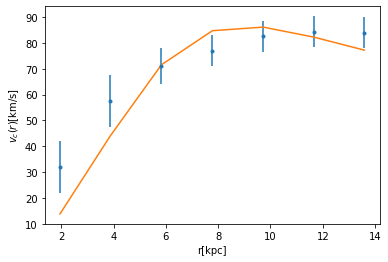

In [104]:
plt.errorbar(vecRp_F571,vecvRp_F571,yerr=vecerrvRp_F571,fmt='.')
plt.plot(vecRp_F571,Vc_xi2(vecRp_F571,np.asscalar(np.exp(LS_m_a_eps_F571.x[0])),np.asscalar(np.exp(LS_m_a_eps_F571.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")